# ***FakeMind-ML4VA Project: Detecting Droughts in Virginia***

Team FakeMind is composed of three UVA students: Alex Fetea, Kamil Urbanowski, and Tyler Kim. FakeMind's goal is to predict droughts in Virginia using a dataset found online. This will help farmers take better care of their farms by taking preparing ahead of time for possible droughts.

The link to the datasets can be found below:

https://resilience.climate.gov/datasets/esri2::us-drought-by-state/explore

https://www.ncei.noaa.gov/products/land-based-station/global-historical-climatology-network-daily


In general, this notebook will store our code for the ML4VA project. This notebook will also be divided into 8 Steps:

1. Big Picture & Setup
2. Getting the Data
3. Discovering and Visualizing the Data
4. Data Cleaning
5. Selecting and Training the Models
6. Fine Tuning the Model
7. Presentation
8. Launch


## **1-Big Picture & Setup**

In [1]:
# import the necessary libraries
import sklearn
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

np.random.seed(17)

## **2-Getting the Data**

In [2]:
def load_data(filepath):
    # Read the dataset
    data = pd.read_csv(filepath)

    # Calculate file size in MB
    file_size = os.path.getsize(filepath) / (1024 * 1024)  # Convert bytes to MB

    # Count number of entries and features
    num_entries, num_features = data.shape

    # Count number of categorical features
    num_categorical = sum(data.dtypes == 'object')

    # Check for missing values
    missing_value_exists = data.isnull().values.any()

    # Print the output
    print("File Size: {:.2f} MB".format(file_size))
    print("Number of Entries:", num_entries)
    print("Number of Features:", num_features)
    print("Do Categorical variables exist:", "Yes" if num_categorical > 0 else "No", "({})".format(num_categorical))
    print("Do missing values exist:", "Yes" if missing_value_exists else "No")
    print("\n")

    print(data.info())
    print(data.describe())

    return data


In [ ]:
# loads the data
drought_data = load_data("datasets/merged_weather_drought.csv")

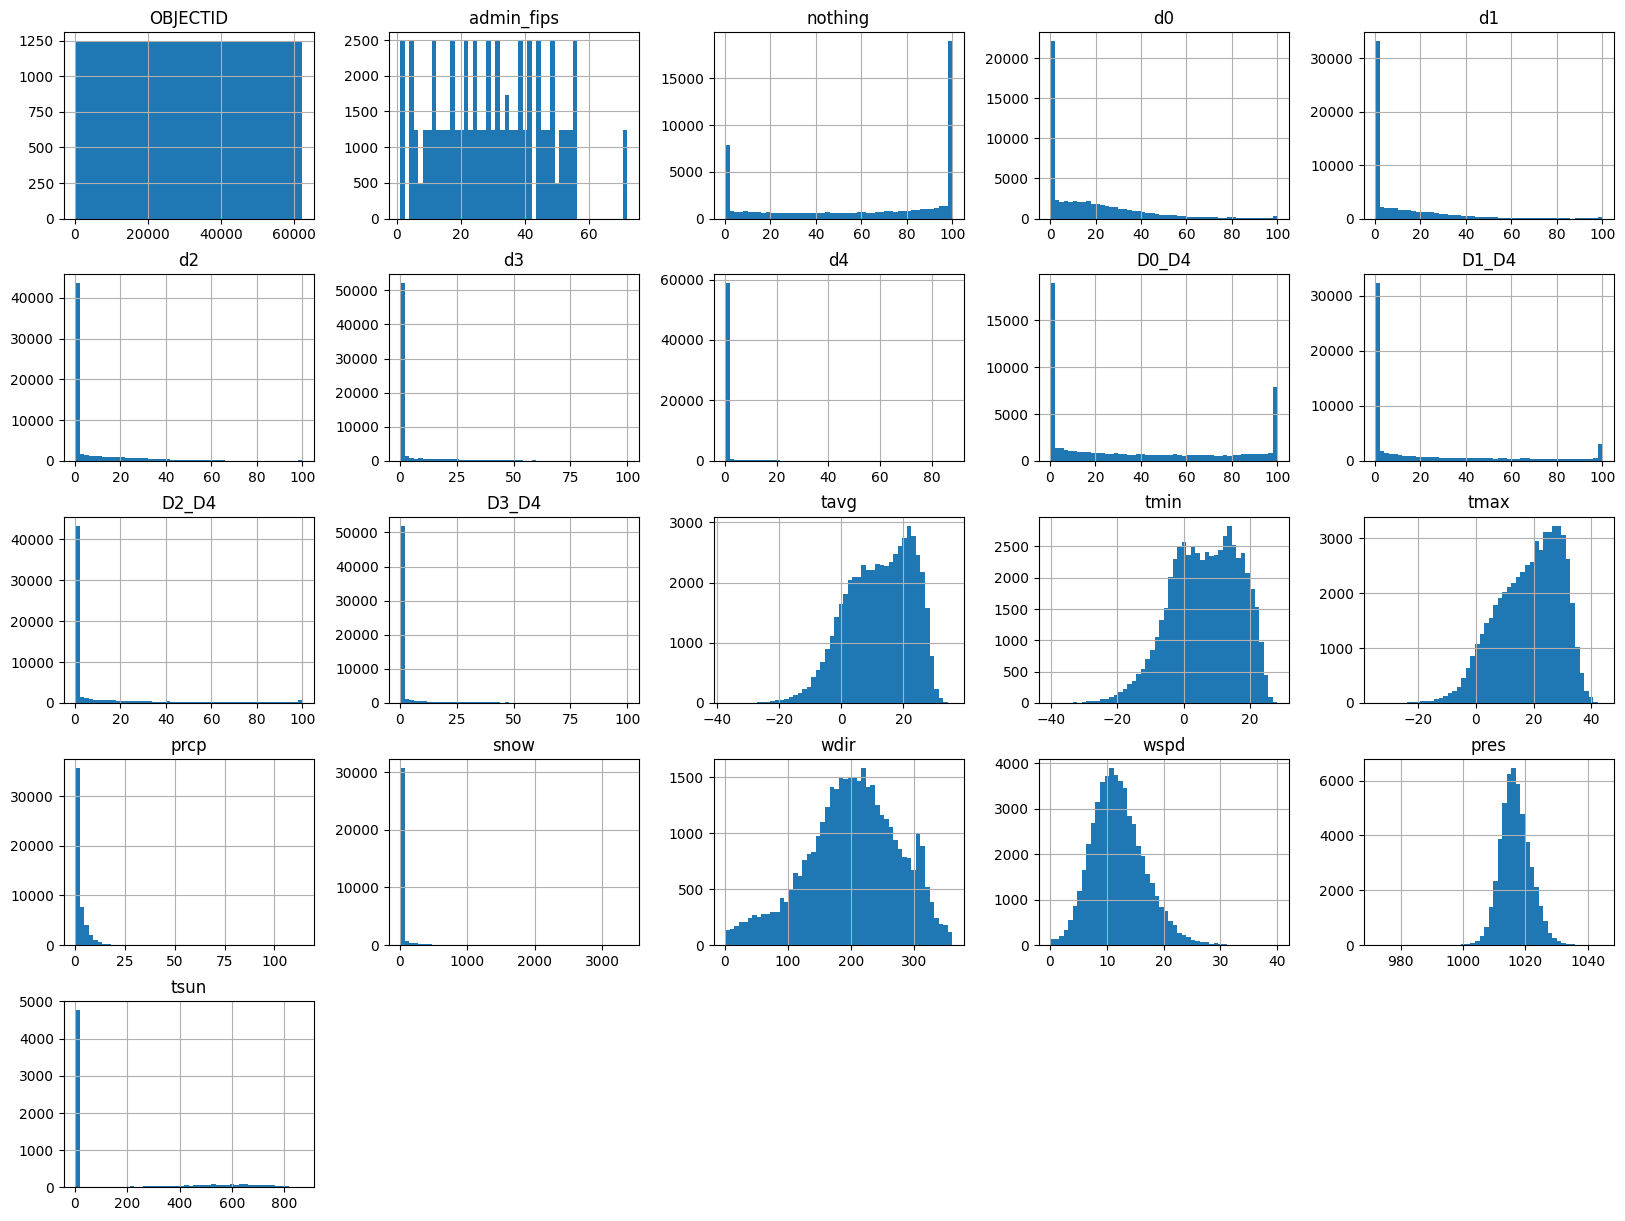

In [43]:
%matplotlib inline
drought_data.hist(bins = 50, figsize = (20, 15))
plt.show()

## **3-Discovering and Visualizing the Data**

          OBJECTID   admin_fips      nothing           d0           d1  \
count   8694.00000  8694.000000  8688.000000  8688.000000  8694.000000   
mean   32758.05107    35.000000    72.557658    15.205475     7.536473   
std    16719.02200    15.391049    35.208546    22.124544    17.306032   
min     4543.00000    11.000000     0.000000     0.000000     0.000000   
25%    15043.25000    21.000000    48.990000     0.000000     0.000000   
50%    33870.50000    37.000000    92.925000     3.535000     0.000000   
75%    46166.25000    51.000000   100.000000    23.750000     6.060000   
max    62309.00000    54.000000   100.000000   100.000000   100.000000   

                d2           d3           d4        D0_D4        D1_D4  ...  \
count  8694.000000  8694.000000  8694.000000  8688.000000  8694.000000  ...   
mean      3.097177     1.221370     0.373401    27.442342    12.228422  ...   
std      11.033349     6.905724     3.592476    35.208546    25.723340  ...   
min       0.00000

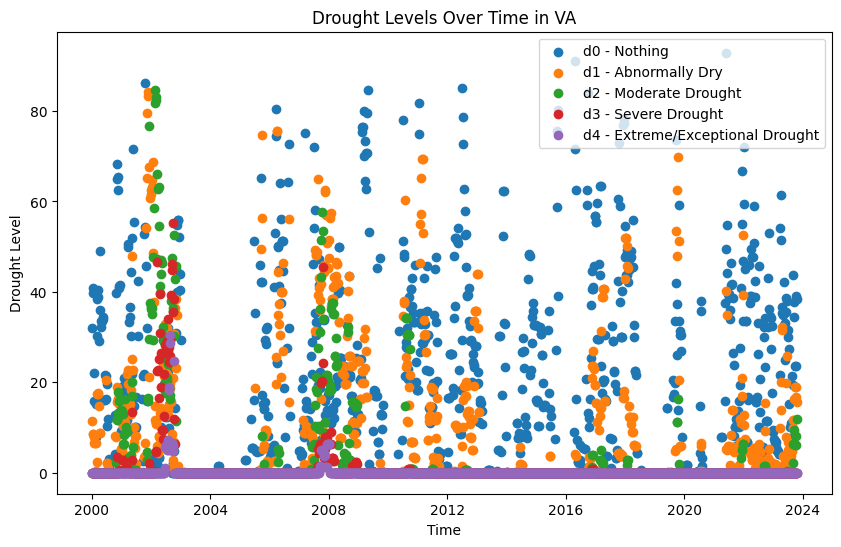

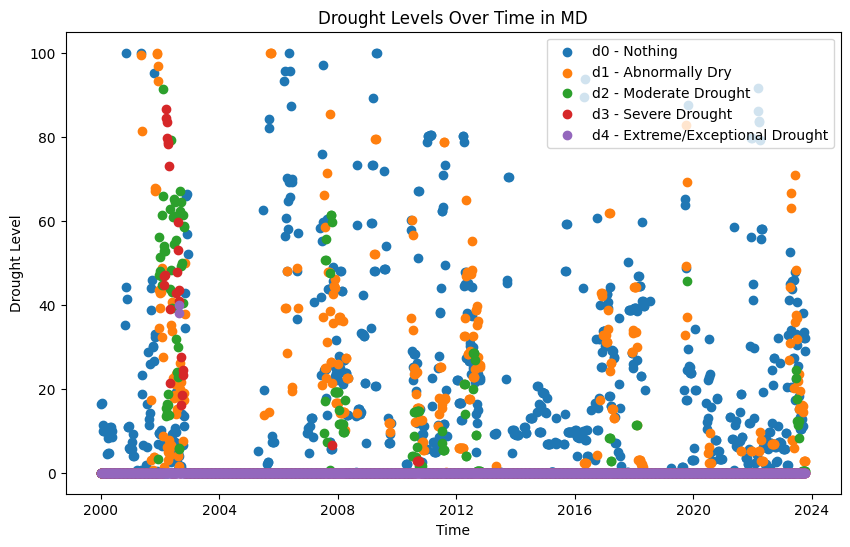

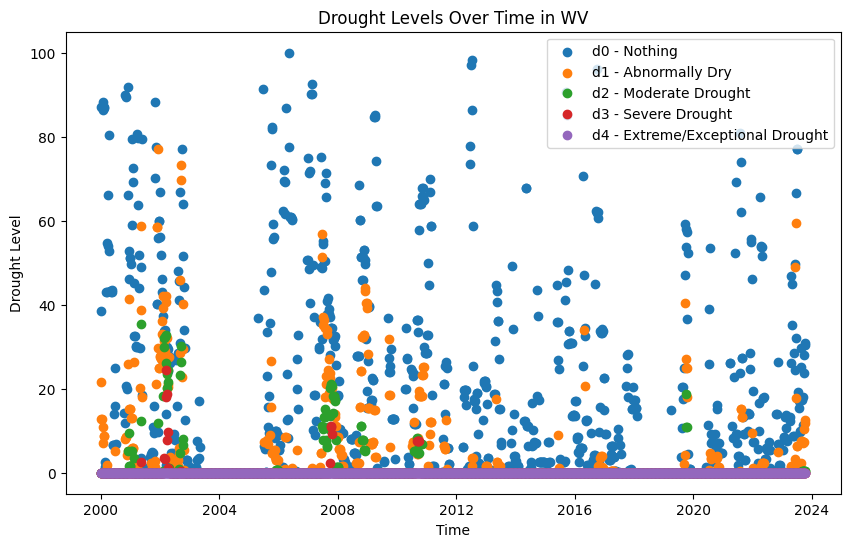

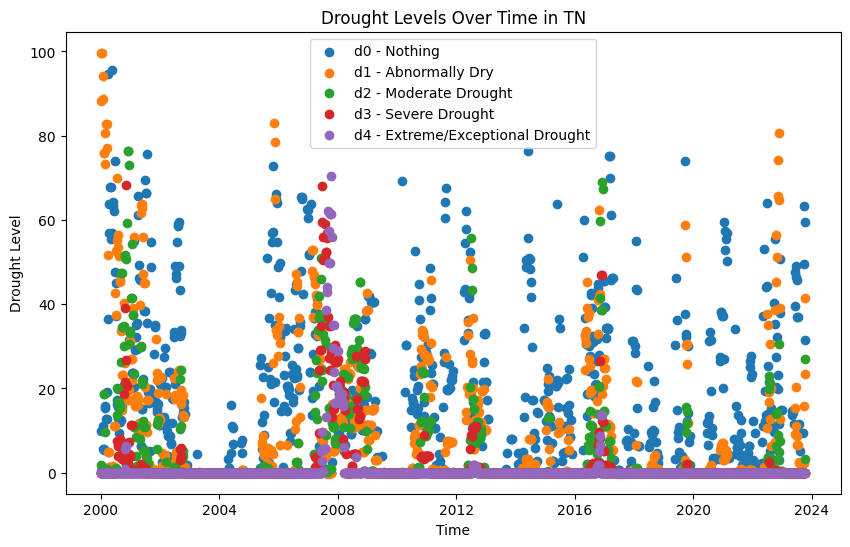

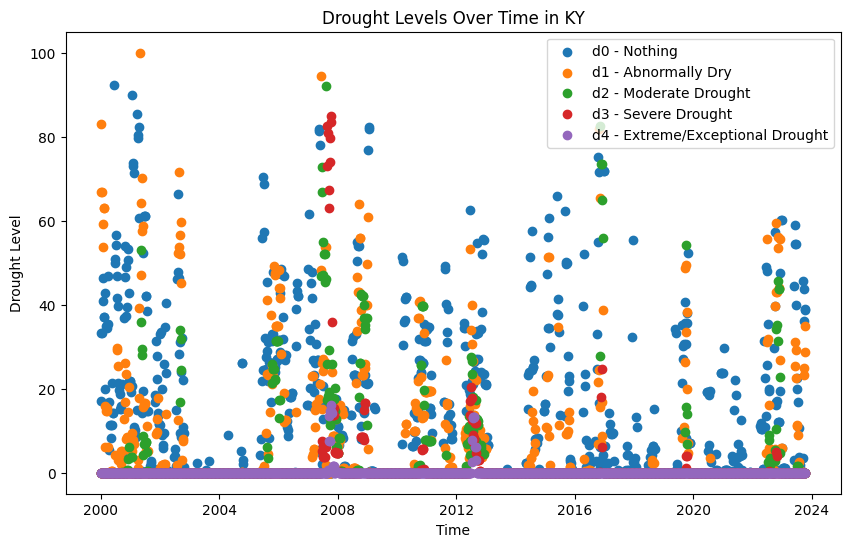

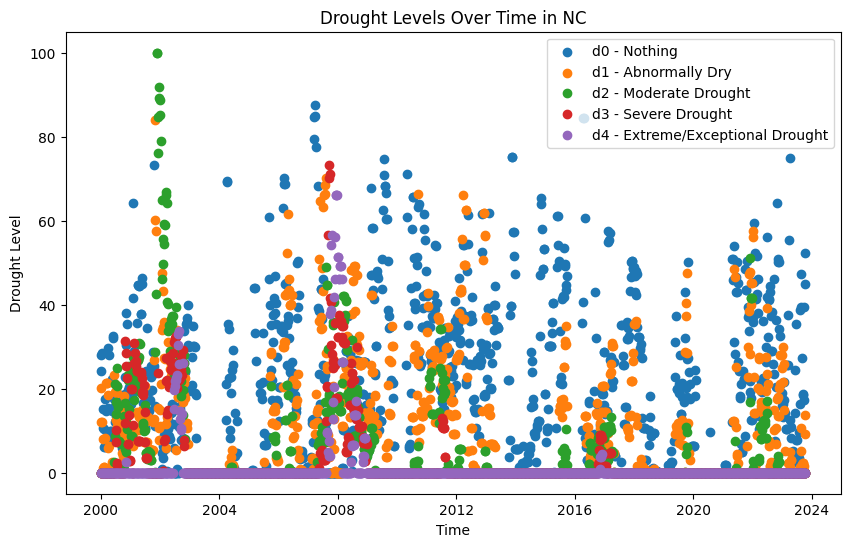

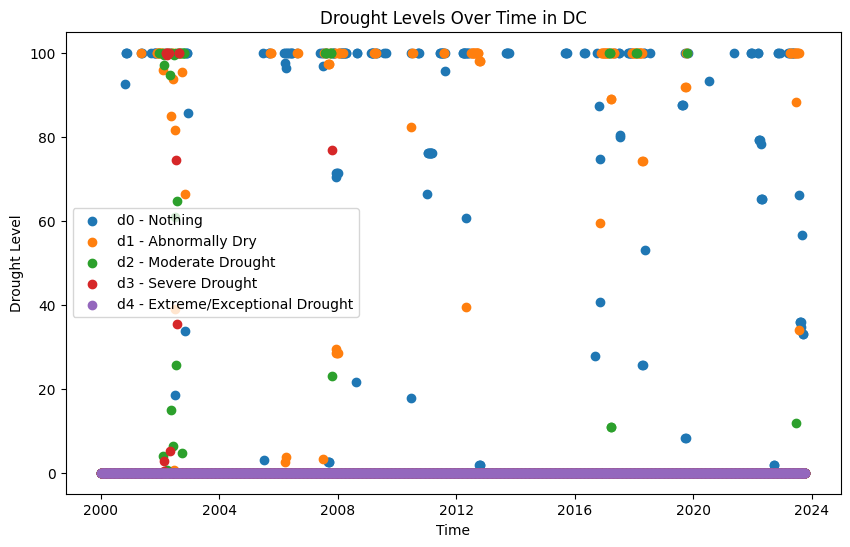

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming drought_data is your original DataFrame

# Filter for states of interest and create a copy
states_of_interest = ["VA", "MD", "WV", "TN", "KY", "NC", "DC"]
sub_df = drought_data[drought_data['state_abbr'].isin(states_of_interest)].copy()

# Convert 'ddate' to datetime
sub_df['ddate'] = pd.to_datetime(sub_df['ddate'])

# Basic Statistics
print(sub_df.describe())

# Create separate scatter plots for each state
for state in states_of_interest:
    plt.figure(figsize=(10, 6))
    state_data = sub_df[sub_df['state_abbr'] == state]

    plt.scatter(state_data['ddate'], state_data['d0'], label="d0 - Nothing")
    plt.scatter(state_data['ddate'], state_data['d1'], label="d1 - Abnormally Dry")
    plt.scatter(state_data['ddate'], state_data['d2'], label="d2 - Moderate Drought")
    plt.scatter(state_data['ddate'], state_data['d3'], label="d3 - Severe Drought")
    plt.scatter(state_data['ddate'], state_data['d4'], label="d4 - Extreme/Exceptional Drought")

    plt.xlabel('Time')
    plt.ylabel('Drought Level')
    plt.title(f'Drought Levels Over Time in {state}')
    plt.legend()
    plt.show()

# Optionally, create a correlation heatmap as previously described...


The scatterplots above represent the level of drought for VA and other adjacent states. It seems as if many of the states have a tendency to be abnormally dry but rarely have anything worse.

## **4-Data Cleaning**

Will drop some features since some of it is redundant.

In [ ]:
from sklearn.model_selection import train_test_split

# Define target and feature columns
output_list = ["nothing", "d0", "d1", "d2", "d3", "d4"]
feature_cols = [col for col in drought_data.columns if col not in output_list and col not in ['D0_D4', 'D1_D4', 'D2_D4', 'D3_D4']]

# Split the data into training and testing sets
train_set, test_set = train_test_split(drought_data, test_size=0.2, random_state=17)

# Separate features and target for training data
X_train = train_set[feature_cols]
y_train = train_set[output_list]

print(y_train.head())
print(X_train.head())

In [45]:
# Test distributions
print(X_train["state_abbr"].value_counts() / len(X_train))
print(drought_data["state_abbr"].value_counts() / len(drought_data))

NH    0.020341
AK    0.020301
AZ    0.020281
MN    0.020241
FL    0.020221
AL    0.020201
MT    0.020201
AR    0.020181
SC    0.020181
WA    0.020181
MI    0.020160
NV    0.020160
OH    0.020160
OR    0.020120
GA    0.020120
MS    0.020100
VA    0.020100
TX    0.020040
IN    0.020020
NC    0.020000
NE    0.020000
KY    0.020000
UT    0.019980
IL    0.019980
DE    0.019960
NJ    0.019940
SD    0.019940
MA    0.019940
MD    0.019940
IA    0.019900
ID    0.019900
NY    0.019860
RI    0.019840
HI    0.019819
WI    0.019819
MO    0.019799
CT    0.019779
CA    0.019719
PA    0.019719
ND    0.019699
WV    0.019699
LA    0.019679
TN    0.019639
OK    0.019639
ME    0.019639
DC    0.019478
WY    0.019478
PR    0.019458
KS    0.019418
CO    0.007763
NM    0.007683
VT    0.007583
Name: state_abbr, dtype: float64
AK    0.019932
PR    0.019932
ND    0.019932
NE    0.019932
NH    0.019932
NJ    0.019932
NV    0.019932
NY    0.019932
OH    0.019932
OK    0.019932
OR    0.019932
PA    0.019932
RI    0

In [47]:

import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# Define the pipeline for numeric and categorical attributes
num_attribs = list(X_train.select_dtypes(include=np.number))
cat_attribs = list(X_train.select_dtypes(exclude=np.number))

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),  # Impute with mean
    ("std_scaler", StandardScaler()),
])

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])

In [46]:
# Apply the full pipeline to the training data
X_train_prepared = full_pipeline.fit_transform(X_train).toarray()

print(y_train)

# Converting to one-hot encoded format
y_train_one_hot = np.zeros_like(y_train.values)
y_train_one_hot[np.arange(len(y_train.values)), y_train.values.argmax(axis=1)] = 1

# Convert back to DataFrame
y_train_one_hot_df = pd.DataFrame(y_train_one_hot, columns=y_train.columns)

print(y_train_one_hot_df.head())


       nothing     d0     d1     d2     d3     d4
45145   100.00   0.00   0.00   0.00   0.00   0.00
30937    53.22  46.78   0.00   0.00   0.00   0.00
38304    19.49  43.02  19.19   0.00  18.30   0.00
4339    100.00   0.00   0.00   0.00   0.00   0.00
35762    71.47  28.53   0.00   0.00   0.00   0.00
...        ...    ...    ...    ...    ...    ...
42297     4.27  11.82  24.89  16.03  21.95  21.04
33174     0.00   0.00  10.25  26.45  29.86  33.44
46470    40.47   8.48  21.50  29.55   0.00   0.00
34959    73.04  26.96   0.00   0.00   0.00   0.00
10863   100.00   0.00   0.00   0.00   0.00   0.00

[49850 rows x 6 columns]
   nothing   d0   d1   d2   d3   d4
0      1.0  0.0  0.0  0.0  0.0  0.0
1      1.0  0.0  0.0  0.0  0.0  0.0
2      0.0  1.0  0.0  0.0  0.0  0.0
3      1.0  0.0  0.0  0.0  0.0  0.0
4      1.0  0.0  0.0  0.0  0.0  0.0


## **5-Selecting and Training the Models**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization, InputLayer

num_samples = X_train_prepared.shape[0]
num_features = X_train_prepared.shape[1]
num_outputs = y_train_one_hot_df.shape[1]
timesteps = X_train_prepared.size // (num_samples * num_features)

# Reshape the data
X_train_prepared_reshaped = X_train_prepared.reshape((num_samples, timesteps, num_features))

# Define hyperparameters
num_units = [50, 50]  # Number of LSTM units in each layer
dropout_rate = 0.3  # Dropout rate
learning_rate = 0.001  # Learning rate
epochs = 14  # Number of training epochs
validation_split = 0.1  # Validation split

# Model building function for RNN classification
def build_rnn_classification_model(input_shape, num_units=num_units, num_outputs=num_outputs, dropout_rate=dropout_rate):
    model = keras.models.Sequential()

    # Input layer
    model.add(keras.layers.InputLayer(input_shape=input_shape))

    # LSTM layers with Bidirectional and Layer Normalization
    for i, n_unit in enumerate(num_units):
        return_sequences = i < len(num_units) - 1
        model.add(Bidirectional(LSTM(n_unit, return_sequences=return_sequences)))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))

    # Output layer for multi-class classification
    model.add(Dense(num_outputs, activation='softmax'))

    # Compile the model
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

# Building and compiling the RNN model
input_shape = (timesteps, num_features)
rnn_classification_model = build_rnn_classification_model(input_shape)

# Model summary
rnn_classification_model.summary()

In [12]:
# Train the model
history = rnn_classification_model.fit(
    X_train_prepared_reshaped,
    y_train_one_hot_df,
    epochs=epochs,
    validation_split=validation_split
)

Epoch 1/14
1403/1403 [==============================] - 27s 10ms/step - loss: 1.1214 - accuracy: 0.6325 - val_loss: 0.8919 - val_accuracy: 0.6931
Epoch 2/14
1403/1403 [==============================] - 12s 9ms/step - loss: 0.8963 - accuracy: 0.6898 - val_loss: 0.8416 - val_accuracy: 0.7031
Epoch 3/14
1403/1403 [==============================] - 12s 8ms/step - loss: 0.8297 - accuracy: 0.7031 - val_loss: 0.8006 - val_accuracy: 0.7087
Epoch 4/14
1403/1403 [==============================] - 12s 8ms/step - loss: 0.7775 - accuracy: 0.7154 - val_loss: 0.7697 - val_accuracy: 0.7172
Epoch 5/14
1403/1403 [==============================] - 12s 8ms/step - loss: 0.7347 - accuracy: 0.7272 - val_loss: 0.7465 - val_accuracy: 0.7248
Epoch 6/14
1403/1403 [==============================] - 13s 9ms/step - loss: 0.6890 - accuracy: 0.7433 - val_loss: 0.7325 - val_accuracy: 0.7286
Epoch 7/14
1403/1403 [==============================] - 12s 9ms/step - loss: 0.6546 - accuracy: 0.7546 - val_loss: 0.7273 - val_a

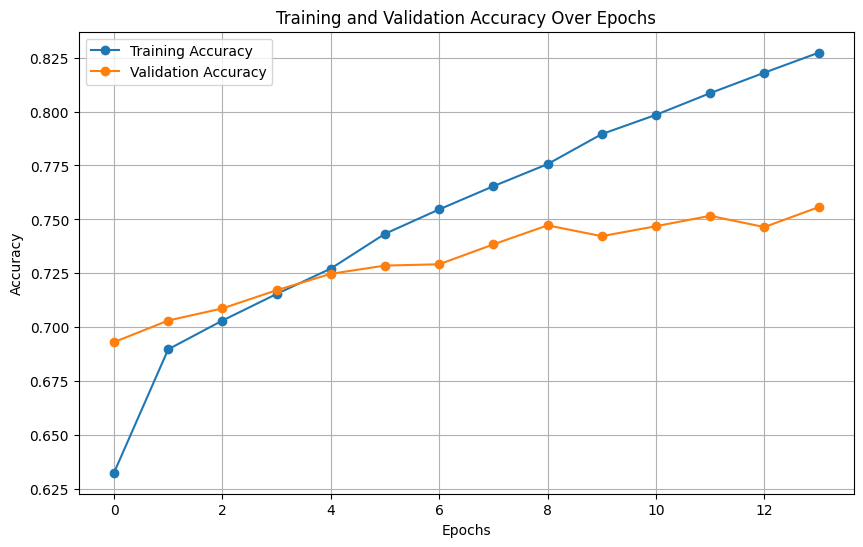

In [28]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy over epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
# Number of features and classes
num_features = X_train_prepared.shape[1]
num_classes = y_train_one_hot_df.shape[1]

# Model building function for multi-class logistic regression
def build_multiclass_logistic_regression_model():
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(num_classes, input_shape=(num_features,), activation='softmax'))

    # Using a lower learning rate for better numerical stability
    learning_rate = 0.001
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Building and compiling the logistic regression model
logistic_regression_model = build_multiclass_logistic_regression_model()

# Model summary
logistic_regression_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 6)                 15282     
                                                                 
Total params: 15282 (59.70 KB)
Trainable params: 15282 (59.70 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [31]:
# Training the model
history2 = logistic_regression_model.fit(
    X_train_prepared, y_train_one_hot_df,
    batch_size=32,
    epochs=10,
    validation_split=0.2  # Using a part of the training set for validation
)

Epoch 1/10
1247/1247 [==============================] - 4s 3ms/step - loss: 1.2193 - accuracy: 0.6668 - val_loss: 1.0016 - val_accuracy: 0.6847
Epoch 2/10
1247/1247 [==============================] - 3s 3ms/step - loss: 0.9558 - accuracy: 0.6860 - val_loss: 0.9473 - val_accuracy: 0.6854
Epoch 3/10
1247/1247 [==============================] - 3s 3ms/step - loss: 0.9108 - accuracy: 0.6868 - val_loss: 0.9282 - val_accuracy: 0.6862
Epoch 4/10
1247/1247 [==============================] - 3s 3ms/step - loss: 0.8852 - accuracy: 0.6893 - val_loss: 0.9197 - val_accuracy: 0.6857
Epoch 5/10
1247/1247 [==============================] - 3s 3ms/step - loss: 0.8678 - accuracy: 0.6894 - val_loss: 0.9159 - val_accuracy: 0.6867
Epoch 6/10
1247/1247 [==============================] - 3s 3ms/step - loss: 0.8550 - accuracy: 0.6910 - val_loss: 0.9155 - val_accuracy: 0.6862
Epoch 7/10
1247/1247 [==============================] - 3s 3ms/step - loss: 0.8456 - accuracy: 0.6923 - val_loss: 0.9164 - val_accuracy:

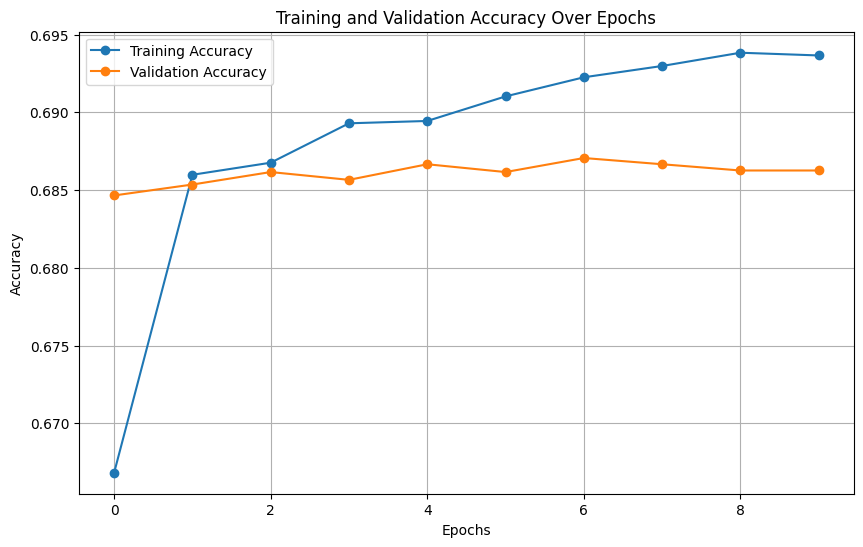

In [32]:
# Plot training and validation accuracy over epochs
plt.figure(figsize=(10, 6))
plt.plot(history2.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [33]:
from keras.layers import Dense, Dropout, BatchNormalization, InputLayer

num_features = X_train_prepared.shape[1]
num_outputs = y_train_one_hot_df.shape[1]

# Define hyperparameters
num_units = [64, 64]  # Number of units in each dense layer
dropout_rate = 0.3  # Dropout rate
learning_rate = 0.001  # Learning rate
epochs = 14  # Number of training epochs
validation_split = 0.1  # Validation split

# Model building function for ANN classification
def build_ann_classification_model(num_features, num_units=num_units, num_outputs=num_outputs, dropout_rate=dropout_rate):
    model = keras.models.Sequential()

    # Input layer
    model.add(InputLayer(input_shape=(num_features,)))

    # Dense layers with Batch Normalization and Dropout
    for n_unit in num_units:
        model.add(Dense(n_unit, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))

    # Output layer for multi-class classification
    model.add(Dense(num_outputs, activation='softmax'))

    # Compile the model
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

# Building and compiling the ANN model
ann_classification_model = build_ann_classification_model(num_features)

# Model summary
ann_classification_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 64)                163008    
                                                                 
 batch_normalization_8 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                                 
 dense_16 (Dense)            (None, 64)                4160      
                                                                 
 batch_normalization_9 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 dropout_9 (Dropout)         (None, 64)               

In [34]:
# Training the model
history3 = ann_classification_model.fit(
    X_train_prepared, y_train_one_hot_df,
    batch_size=32,
    epochs=10,
    validation_split=validation_split
)

Epoch 1/10
1403/1403 [==============================] - 9s 5ms/step - loss: 1.1584 - accuracy: 0.6261 - val_loss: 0.9118 - val_accuracy: 0.6909
Epoch 2/10
1403/1403 [==============================] - 8s 6ms/step - loss: 0.9220 - accuracy: 0.6874 - val_loss: 0.8728 - val_accuracy: 0.6959
Epoch 3/10
1403/1403 [==============================] - 7s 5ms/step - loss: 0.8725 - accuracy: 0.6930 - val_loss: 0.8483 - val_accuracy: 0.7007
Epoch 4/10
1403/1403 [==============================] - 7s 5ms/step - loss: 0.8325 - accuracy: 0.7013 - val_loss: 0.8227 - val_accuracy: 0.7069
Epoch 5/10
1403/1403 [==============================] - 6s 4ms/step - loss: 0.7947 - accuracy: 0.7086 - val_loss: 0.8063 - val_accuracy: 0.7085
Epoch 6/10
1403/1403 [==============================] - 7s 5ms/step - loss: 0.7636 - accuracy: 0.7197 - val_loss: 0.7925 - val_accuracy: 0.7077
Epoch 7/10
1403/1403 [==============================] - 6s 5ms/step - loss: 0.7311 - accuracy: 0.7286 - val_loss: 0.7819 - val_accuracy:

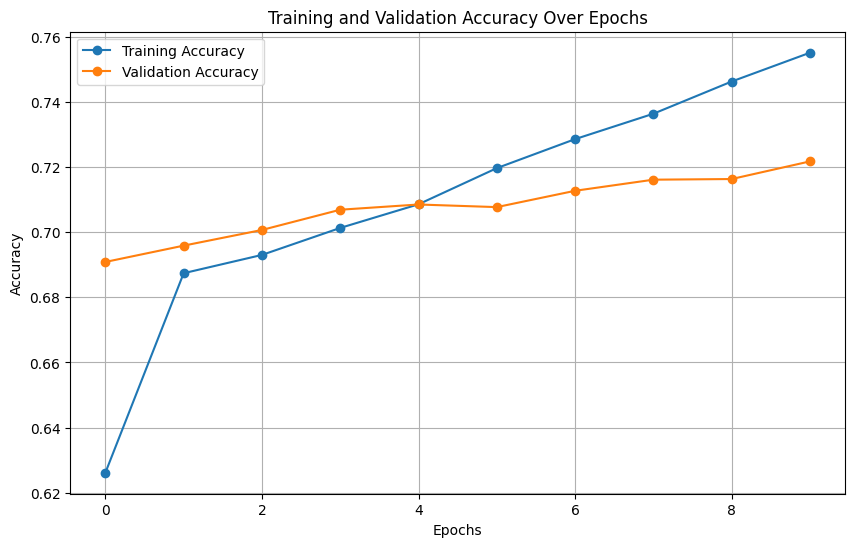

In [35]:
# Plot training and validation accuracy over epochs
plt.figure(figsize=(10, 6))
plt.plot(history3.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history3.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [38]:
from keras.layers import SimpleRNN, Dense, Dropout, Bidirectional, BatchNormalization, InputLayer

num_samples = X_train_prepared.shape[0]
num_features = X_train_prepared.shape[1]
num_outputs = y_train_one_hot_df.shape[1]
timesteps = X_train_prepared.size // (num_samples * num_features)

# Reshape the data
X_train_prepared_reshaped = X_train_prepared.reshape((num_samples, timesteps, num_features))

# Define hyperparameters
num_units = [50, 50]  # Number of units in each SimpleRNN layer
dropout_rate = 0.3  # Dropout rate
learning_rate = 0.001  # Learning rate
epochs = 14  # Number of training epochs
validation_split = 0.1  # Validation split

# Model building function for RNN classification w/o LSTM
def build_rnn_classification_model(input_shape, num_units=num_units, num_outputs=num_outputs, dropout_rate=dropout_rate):
    model = keras.models.Sequential()

    # Input layer
    model.add(InputLayer(input_shape=input_shape))

    # SimpleRNN layers with Bidirectional and Batch Normalization
    for i, n_unit in enumerate(num_units):
        return_sequences = i < len(num_units) - 1
        model.add(Bidirectional(SimpleRNN(n_unit, return_sequences=return_sequences)))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))

    # Output layer for multi-class classification
    model.add(Dense(num_outputs, activation='softmax'))

    # Compile the model
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

# Building and compiling the RNN model without LSTM
input_shape = (timesteps, num_features)
rnn_classification_model = build_rnn_classification_model(input_shape)

# Model summary
rnn_classification_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_4 (Bidirecti  (None, 1, 100)            259700    
 onal)                                                           
                                                                 
 batch_normalization_12 (Ba  (None, 1, 100)            400       
 tchNormalization)                                               
                                                                 
 dropout_12 (Dropout)        (None, 1, 100)            0         
                                                                 
 bidirectional_5 (Bidirecti  (None, 100)               15100     
 onal)                                                           
                                                                 
 batch_normalization_13 (Ba  (None, 100)               400       
 tchNormalization)                                   

In [40]:
# Training the model
history4 = rnn_classification_model.fit(
    X_train_prepared_reshaped, y_train_one_hot_df,
    batch_size=32,
    epochs=10,
    validation_split=validation_split
)

Epoch 1/10
1403/1403 [==============================] - 13s 9ms/step - loss: 1.0712 - accuracy: 0.6539 - val_loss: 0.9126 - val_accuracy: 0.6903
Epoch 2/10
1403/1403 [==============================] - 12s 9ms/step - loss: 0.9284 - accuracy: 0.6835 - val_loss: 0.8865 - val_accuracy: 0.6929
Epoch 3/10
1403/1403 [==============================] - 12s 9ms/step - loss: 0.8927 - accuracy: 0.6888 - val_loss: 0.8692 - val_accuracy: 0.6975
Epoch 4/10
1403/1403 [==============================] - 12s 9ms/step - loss: 0.8636 - accuracy: 0.6931 - val_loss: 0.8552 - val_accuracy: 0.6997
Epoch 5/10
1403/1403 [==============================] - 12s 9ms/step - loss: 0.8388 - accuracy: 0.7002 - val_loss: 0.8450 - val_accuracy: 0.7005
Epoch 6/10
1403/1403 [==============================] - 12s 9ms/step - loss: 0.8198 - accuracy: 0.7049 - val_loss: 0.8284 - val_accuracy: 0.7079
Epoch 7/10
1403/1403 [==============================] - 12s 9ms/step - loss: 0.8030 - accuracy: 0.7080 - val_loss: 0.8228 - val_ac

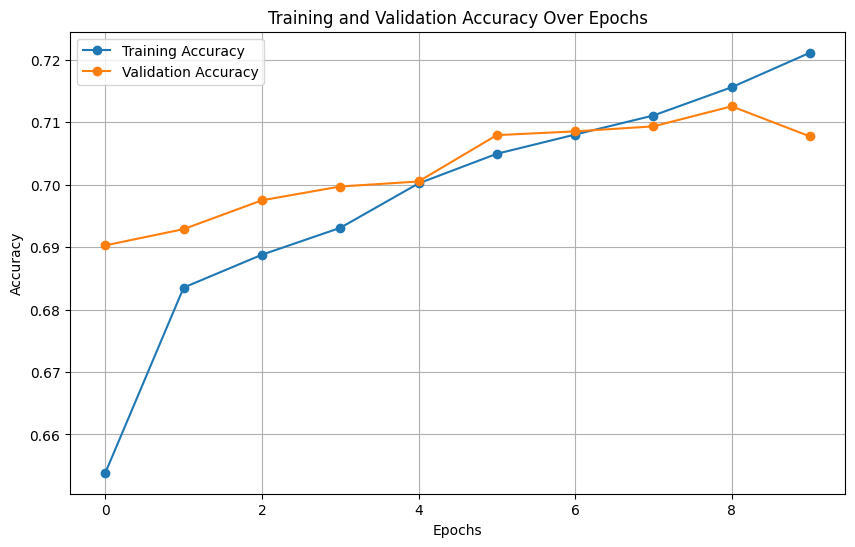

In [41]:
# Plot training and validation accuracy over epochs
plt.figure(figsize=(10, 6))
plt.plot(history4.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history4.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [42]:
keras.backend.clear_session()
np.random.seed(42)